<a href="https://colab.research.google.com/github/Francis-Mwaniki/jupyter-tensorflow/blob/main/Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression
  ### introduction

In [2]:
!pip install -q sklearn

  Preparing metadata (setup.py) ... done


In [3]:
%tensorflow_version 2.x  # this line is not required unless you are in a notebook

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf

In [5]:
dftrain=pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval=pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train=dftrain.pop('survived')
y_eval=dfeval.pop('survived')
dftrain.head()


,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


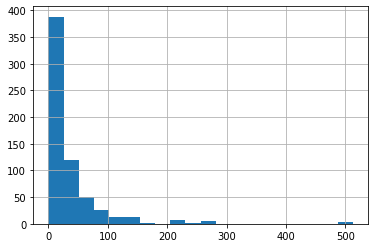

In [6]:
dftrain.fare.hist(bins=20)

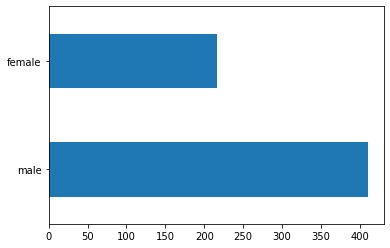

In [7]:
dftrain.sex.value_counts().plot(kind='barh')

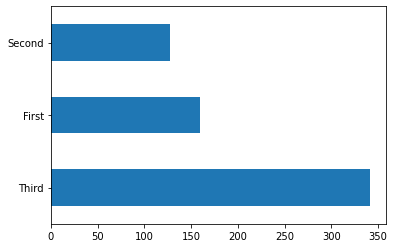

In [8]:
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

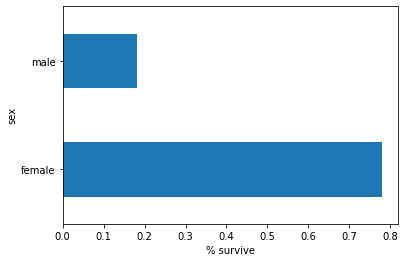

In [9]:
pd.concat([dftrain,y_train],axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

In [10]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

**Def Input Fn**


Feeding input to the model using epoch

In [12]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)


***Creating the Model***

In [13]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# We create a linear estimtor by passing the feature columns we created earlier

***Training the model***

In [14]:
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on tetsing data

clear_output()  # clears consoke output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model

0.7689394


And we now we have a model with a 74% accuracy (this will change each time)! Not crazy impressive but decent for our first try.

Now let's see how we can actually use this model to make predicitons.

We can use the ```.predict()``` method to get survival probabilities from the model. This method will return a list of dicts that store a predicition for each of the entries in our testing data set. Below we've used some pandas magic to plot a nice graph of the predictions.

As you can see the survival rate is not very high :/

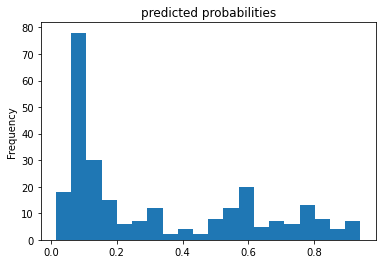

In [15]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')